In this example, we will demonstrate how to get the neutron flux as a function of energy (commonly called a flux spectrum). We will use a pre-built module from the `openmc.examples` package.

In [1]:
%matplotlib inline
import openmc.examples
import numpy as np
import matplotlib.pyplot as plt

First, we'll generate a pin-cell model:

In [2]:
model = openmc.examples.pwr_pin_cell()

By default, the model has no tallies.

In [3]:
model.tallies

[]

To get the flux spectrum, we just need to create a flux tally with an energy filter. We can take advantage of numpy to get an energy filter specifying equal-lethargy bins. Let's create an energy filter with 500 energy bins.

In [4]:
# Create equal-lethargy energies to put in filter
energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 501)
e_filter = openmc.EnergyFilter(energies)

# Create tally with energy filter
tally = openmc.Tally()
tally.filters = [e_filter]
tally.scores = ['flux']

# Set model tallies
model.tallies = [tally]

Now let's run the model (making sure to set the number of particles/batches slightly higher than the default values).

In [5]:
model.settings.particles = 10000
model.settings.batches = 50
model.run(output=False)

1.1611140430383335+/-0.001560877297529439

Great, the simulation is done. To get our results, we need to load data from the statepoint file.

In [6]:
sp = openmc.StatePoint('statepoint.50.h5')

We can now get the corresponding tally from the statepoint file and get the mean values for each energy bin by using the `mean` attribute on the tally.

In [7]:
t = sp.tallies[tally.id]
flux = t.mean.ravel()
flux_unc = t.std_dev.ravel()

Now we can use matplotlib to plot the flux versus the energy.

Text(0,0.5,'Flux [n/cm-src]')

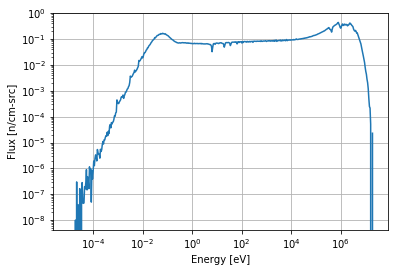

In [8]:
plt.loglog(energies[:-1], flux)
plt.grid()
plt.xlabel('Energy [eV]')
plt.ylabel('Flux [n/cm-src]')